### Import

In [83]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal as mnorm
from mpl_toolkits import mplot3d
from scipy import ndimage
from matplotlib import cm

### Fonts

In [84]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Read OBJ file

In [74]:
plt.ion()
index = 0
indices = []
lines = []
vertices = []
with open('../../meta/surfaces/nurbs_2.obj','r') as f:
    for line in f:
        lines.append(line)
        if ('v ' == line[:2]):
            elements = line.rstrip().split(' ')[1:]
            elements = np.array(elements).astype(float)
            vertices.append(elements)
            indices.append(index)
            index = index + 1
vertices = np.array(vertices)

### Convert to Matrix

In [87]:
dim = int(np.sqrt(vertices.shape[0]))
xmap = np.reshape(vertices[:,0],(dim,dim))
ymap = np.reshape(vertices[:,2],(dim,dim))
height_map = np.reshape(vertices[:,1],(dim,dim))
dim = xmap.shape[0]

### Create Surface

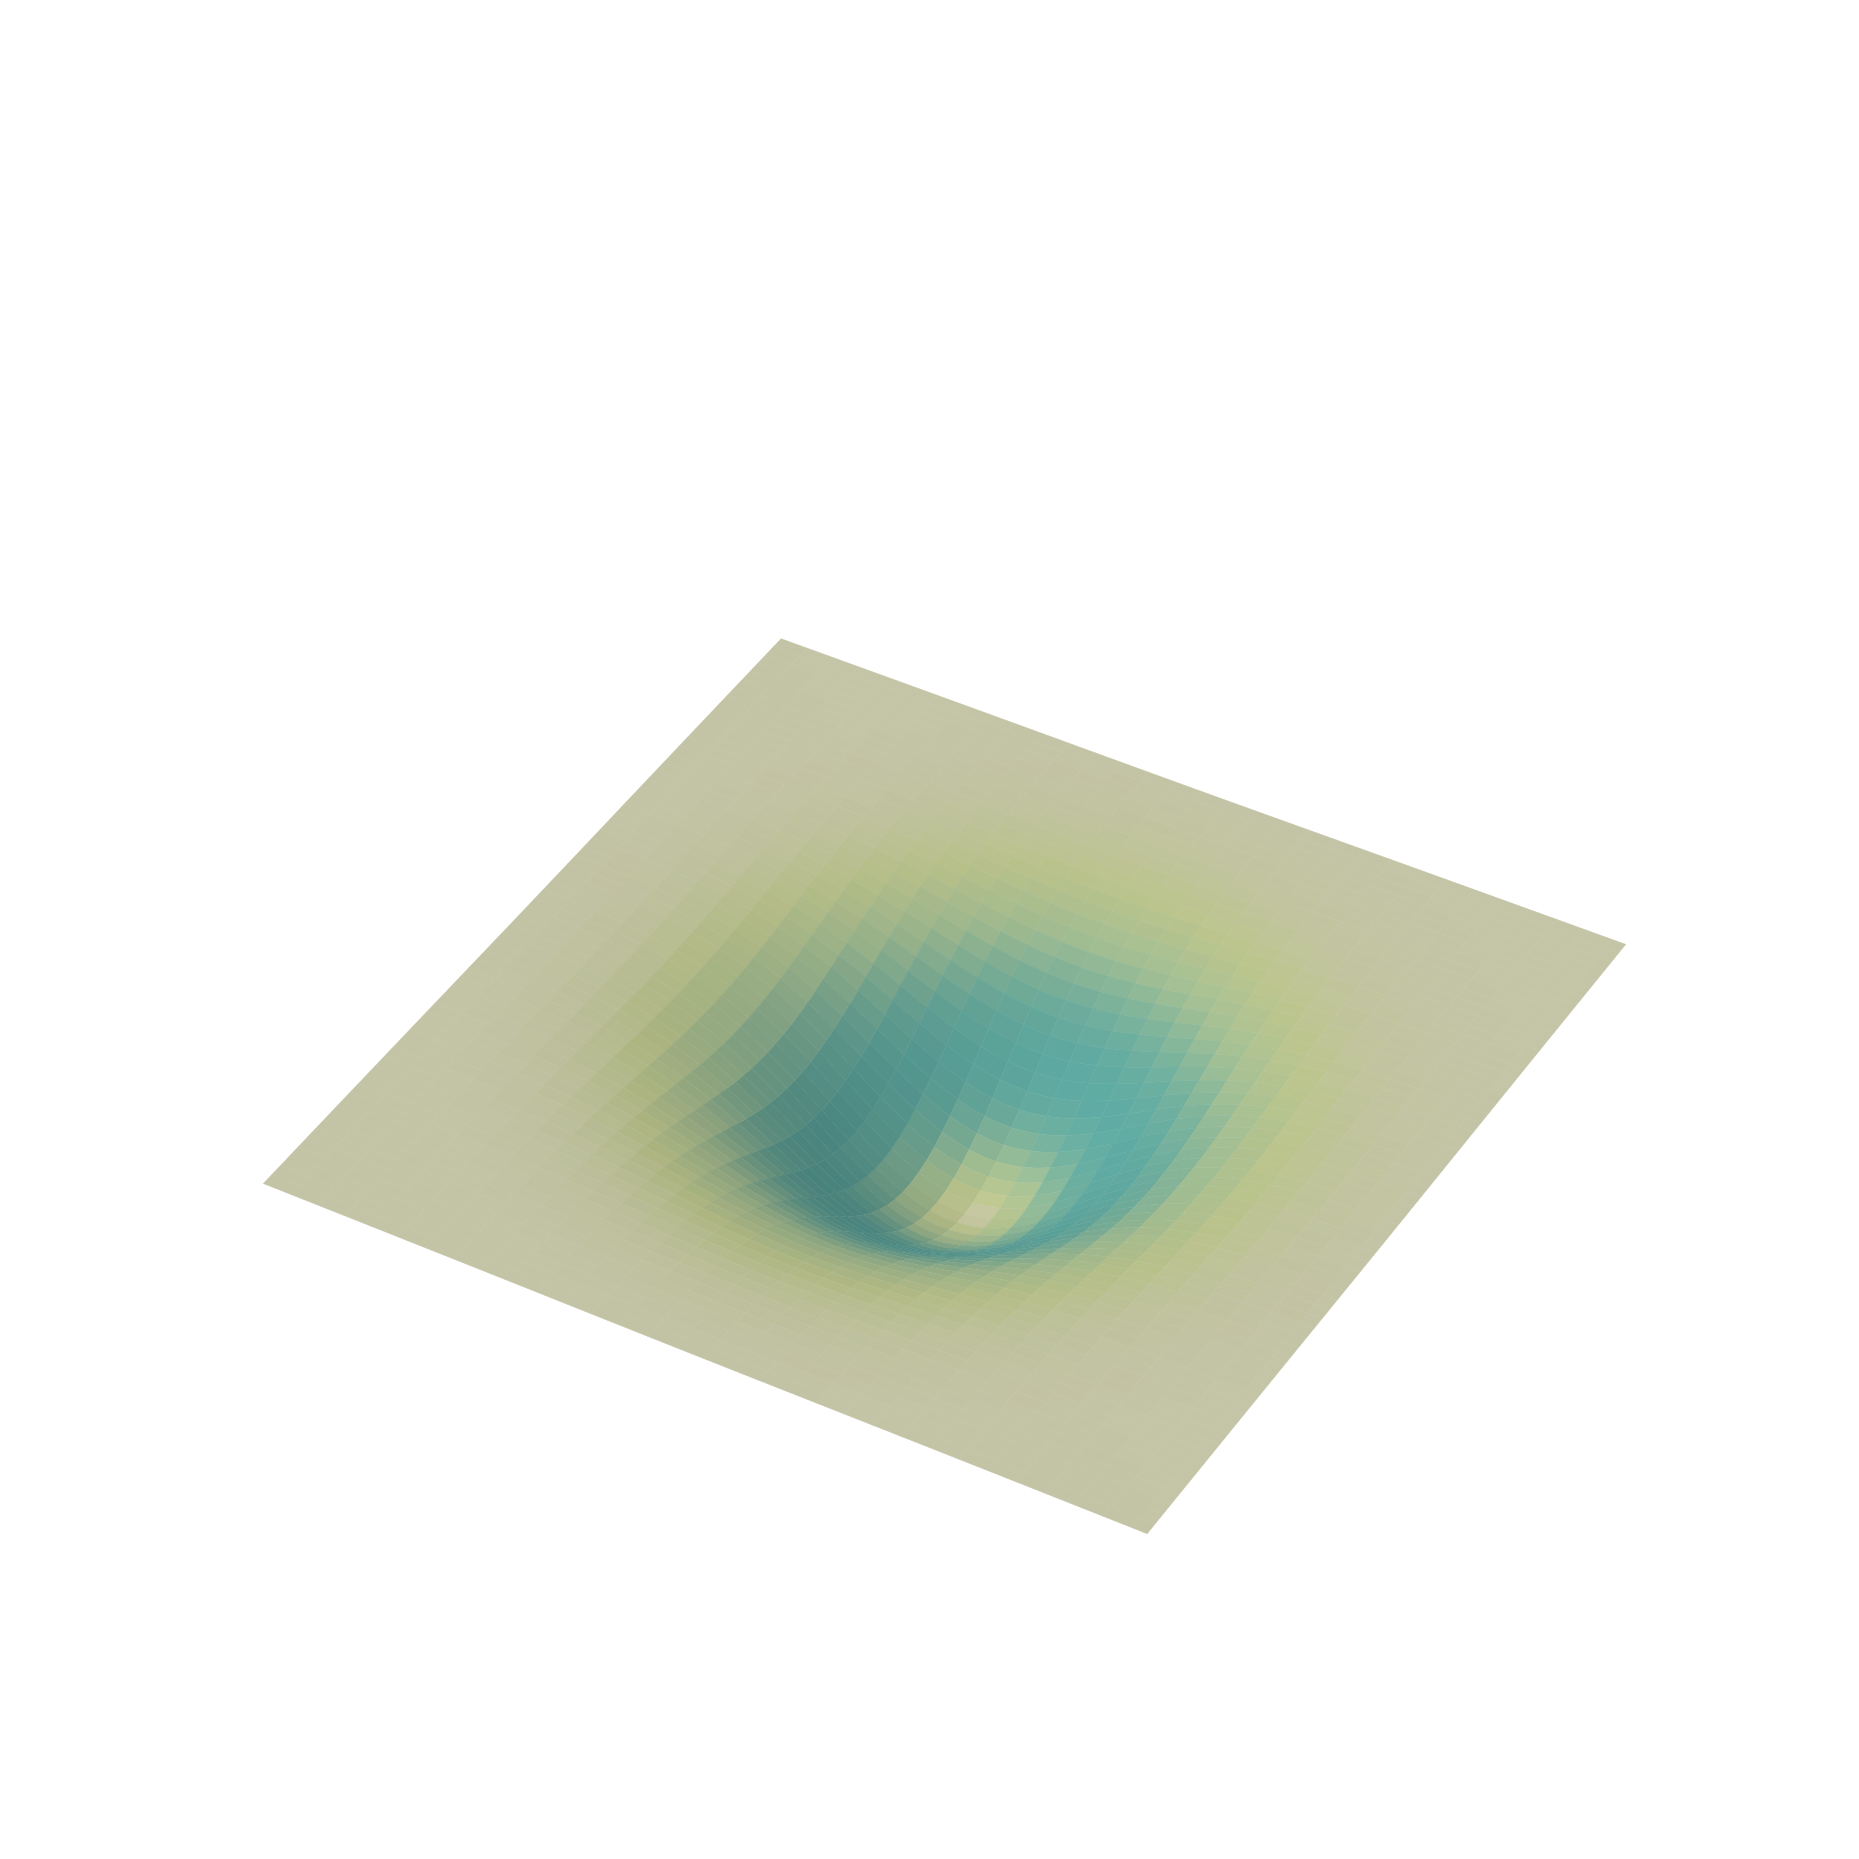

In [98]:
#Create Mesh Grid
xval = np.linspace(-1.5, 1.5, dim)
yval = np.linspace(-1.5, 1.5, dim)
[xm,ym] = np.meshgrid(xval, yval)
xmf = xm.flatten()
ymf = ym.flatten()
P = np.vstack((xmf,ymf)).T
distr = mnorm([0,0],[[0.2,0],[0,0.2]])
z = -distr.pdf(P)
z = np.reshape(z,((dim,dim))) 

#Sobel
sx = ndimage.sobel(z,axis=0,mode='constant')
sy = ndimage.sobel(z,axis=1,mode='constant')
sobel=np.hypot(sx,sy)
sobel[:,0] = sobel[:,1]
sobel[:,-1] = sobel[:,-2]
sobel[0,:] = sobel[1,:]
sobel[-1,:] = sobel[-2,:]

#Colors for gradient
gn = sobel - np.min(sobel)
gradient_colors = cm.YlGnBu(gn)
gn = gn / np.max(gn) * 0.25

zn = z - np.min(z)
loss_colors = cm.YlGnBu(zn)
zn = zn / np.max(zn) * 0.25

fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot_surface(xm, ym, zn, alpha=1.0, 
                rstride=1, cstride=2, antialiased = True,
                facecolors = gradient_colors,
                color=(0.95,0.95,0.95),linewidth=0.1,
                edgecolor='k',shade=True)
ax.set_xticks(np.linspace(-1.5,1.5,11),labels=np.round(np.linspace(-1.5,1.5,11),2),fontsize=14,**csfont);
ax.set_yticks(np.linspace(-1.5,1.5,11),labels=np.round(np.linspace(-1.5,1.5,11),2),fontsize=14,**csfont);
ax.set_zticks(np.linspace(0.0,1.0,5),labels=np.round(np.linspace(0.0,1.0,5),2),fontsize=14,**csfont);
ax.set_xlabel('\na',fontsize=22,**csfont);
ax.set_ylabel('\nb',fontsize=22,**csfont);
xlm = ax.get_xlim3d()
ylm = ax.get_ylim3d()
zlm = ax.get_zlim3d()
ax.set_xlim3d(xlm[0] * 1.0, xlm[1] * 1.0)
ax.set_ylim3d(ylm[0] * 1.0, ylm[1] * 1.0)
ax.set_zlim3d(zlm[0] * 1.0, zlm[1] * 1.0)
azm = ax.azim
plt.axis('off')
elevation = ax.elev + 10
ax.view_init(elev=elevation, azim=azm)
plt.savefig('../../assets/matplotlib/014_gd_4.png', dpi=300,bbox_inches="tight")

### Put back and save

In [71]:
index = 0
vertices[:,1] = zn.flatten() * 10.0
with open('../../meta/surfaces/nurbs_3_converted.obj','w') as f:
    for line in lines:
        if ('v ' == line[:2]):
            vertex = vertices[index,:]
            newline = 'v ' + str(np.round(vertex[0],6)) + ' ' + str(np.round(vertex[1],6)) + ' ' + str(np.round(vertex[2],6)) + '\n'
            index = index + 1
            f.write(newline)
        else:
            f.write(line)

### Save Textures

In [72]:
G = np.uint8(255*gradient_colors[:,:,0].T)
G = np.fliplr(G)
img = Image.fromarray(G)
img.save('../../meta/surfaces/gradient.png')

L = np.uint8(255*loss_colors[:,:,0].T)
L = np.fliplr(L)
img = Image.fromarray(L)
img.save('../../meta/surfaces/loss.png')